#  Neural Style Transfer

In [58]:
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
# transfer learning with keras https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e
# import tensorflow as tf
import tensorflow.compat.v1 as tf   # this line is using so that can use precious version function so we need not to shift to previous versoin
tf.disable_v2_behavior()
# https://www.analyticsvidhya.com/blog/2020/10/introduction-and-implementation-to-neural-style-transfer-deep-learning/
%matplotlib inline

In [59]:
class CONFIG:
    IMAGE_WIDTH = 712
    IMAGE_HEIGHT = 474
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    
def load_vgg_model(path):
    
    print(path)
    
#     https://in.mathworks.com/help/deeplearning/ref/vgg19.html
     
    """"
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    print(vgg.keys())  #dict_keys(['__header__', '__version__', '__globals__', 'layers', 'meta'])

    print(vgg['layers'].shape)    #(1, 43)
#     print(vgg.shape)   dict has no shape
    print(type(vgg))
#     print(vgg)
#     print(vgg['layers'])
    print(type(vgg['layers']))
    

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        
        wb = vgg_layers[0][layer][0][0][2]
#         print(wb)
#         print(vgg_layers[0][layer].shape)
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b


    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
#         print(W.shape,b.shape)
        
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.  only extracting the weight of conv layer other manully
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    print(graph['input'])
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    print(graph['conv1_1'])
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    print(graph['conv1_1'])
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    print(graph['avgpool1'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    print(graph['conv2_1'])
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    print(graph['conv2_2'])
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    print(graph['avgpool2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    print(graph['conv3_1'])
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    print(graph['conv3_2'])
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    print(graph['conv3_3'])
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    print(graph['conv3_4'])
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    print(graph['avgpool3'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    print(graph['conv4_1'])
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    print(graph['conv4_2'])
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    print(graph['conv4_3'])
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    print(graph['conv4_4'])
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    print(graph['avgpool4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    print(graph['conv5_1'])
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    print(graph['conv5_2'])
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    print(graph['conv5_3'])
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    print(graph['conv5_4'])
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    print(graph['avgpool5'])
    
    return graph

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    
#     Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the
#     generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the
#     "generated" image more rapidly match the content of the "content" image.
    noise_image = np.random.uniform(-20, 20, (1,content_image.shape[1],content_image.shape[2],content_image.shape[3] )).astype('float32')
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image


def reshape_and_normalize_image(image):
    
    image = np.reshape(image, ((1,) + image.shape))
    print(image.shape)
    image = image - CONFIG.MEANS
    
    return image


def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    plt.imsave(path, image)


We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 


(400, 300, 3)


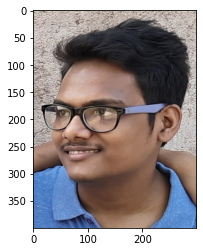

In [60]:
content_image = plt.imread("images/c_i.jpeg")
imshow(content_image)
print(content_image.shape)
CONFIG.IMAGE_WIDTH=content_image.shape[1]
CONFIG.IMAGE_HEIGHT=content_image.shape[0]
CONFIG.COLOR_CHANNELS=content_image.shape[2]

In [61]:

def compute_content_cost(a_C, a_G):
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(a_C.shape)
    print(a_G.shape)
    a_C_unrolled = tf.reshape(a_C, shape = [m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape = [m, n_H, n_W, n_C])
    print(a_C.shape)
    print(a_G.shape)
    print(a_G_unrolled)
    print(a_C_unrolled)
    print(type(a_C))
    print(type(a_G))
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    return J_content

### Computing the style cost



In [62]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

###  Style cost


$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


In [63]:
def compute_layer_style_cost(a_S, a_G):

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, shape = [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, shape = [n_H * n_W, n_C])
    print(a_S.shape)
    print(a_G.shape)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    print(GS.shape)
    print(GG.shape)

    J_style_layer = (tf.reduce_sum(tf.square(GS - GG)))/(4 * n_C**2 * (n_H * n_W)**2)
    
    
    return J_style_layer

In [64]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [65]:
def compute_style_cost(model, STYLE_LAYERS):
   
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]  # out is the node of graph at layer layer_name

        a_S = sess.run(out)   # executing that node with style image as input

        a_G = out                     
        print(a_S)
        print(a_G)
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        J_style += coeff * J_style_layer

    return J_style

### 3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [66]:
def total_cost(J_content, J_style, alpha = 10000, beta = 20000):
    J = alpha * J_content + beta * J_style
    return J

In [67]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

# sess = tf.InteractiveSession()
# a = tf.constant(5.0)
# b = tf.constant(6.0)
# c = a * b
# # We can just use 'c.eval()' without passing 'sess'
# print(c.eval())
# sess.close()
# The only difference between Session and an InteractiveSession is that InteractiveSession makes itself the default session so that you can call run() or eval() without explicitly calling the session.
# 
# This can be helpful if you experiment with TF in python shell or in Jupyter notebooks, because it avoids having to pass an explicit Session object to run operations.

In [68]:
content_image = plt.imread("images/c_i.jpeg")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)   # doing a/c to vgg requirement
print(content_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


In [69]:
style_image = plt.imread("images/style.jpeg")
print(style_image.shape)
style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)

(400, 300, 3)
(1, 400, 300, 3)
(1, 400, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


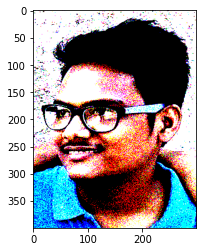

In [70]:
# print(content_image.shape)
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [71]:
# VGG19
# So in simple language VGG is a deep CNN used to classify images. The layers in VGG19 model are as follows:
# input
# Conv3x3 (64)
# Conv3x3 (64)
# MaxPool
# Conv3x3 (128)
# Conv3x3 (128)
# MaxPool
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# Conv3x3 (256)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# Conv3x3 (512)
# MaxPool
# ignore fully connect none of our use
# Fully Connected (4096)
# Fully Connected (4096)
# Fully Connected (1000)
# SoftMax
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")


pretrained-model/imagenet-vgg-verydeep-19.mat
dict_keys(['__header__', '__version__', '__globals__', 'layers', 'meta'])
(1, 43)
<class 'dict'>
<class 'numpy.ndarray'>
<tf.Variable 'Variable:0' shape=(1, 400, 300, 3) dtype=float32_ref>
Tensor("Relu:0", shape=(1, 400, 300, 64), dtype=float32)
Tensor("Relu:0", shape=(1, 400, 300, 64), dtype=float32)
Tensor("AvgPool:0", shape=(1, 200, 150, 64), dtype=float32)
Tensor("Relu_2:0", shape=(1, 200, 150, 128), dtype=float32)
Tensor("Relu_3:0", shape=(1, 200, 150, 128), dtype=float32)
Tensor("AvgPool_1:0", shape=(1, 100, 75, 128), dtype=float32)
Tensor("Relu_4:0", shape=(1, 100, 75, 256), dtype=float32)
Tensor("Relu_5:0", shape=(1, 100, 75, 256), dtype=float32)
Tensor("Relu_6:0", shape=(1, 100, 75, 256), dtype=float32)
Tensor("Relu_7:0", shape=(1, 100, 75, 256), dtype=float32)
Tensor("AvgPool_2:0", shape=(1, 50, 38, 256), dtype=float32)
Tensor("Relu_8:0", shape=(1, 50, 38, 512), dtype=float32)
Tensor("Relu_9:0", shape=(1, 50, 38, 512), dtype=float

In [72]:
# sess.run(model['input'].assign(content_image))   # initialise tf varible with content image

# out = model['conv4_2']        #sitting on node of graph at con4_2
# # print(out)
# a_C = sess.run(out)               # out input as content image
# # print(a_C.shape)
# # imshow(a_C)
# # print('aaaafsadf')
# a_G = out
# # print(a_G)
# # a_G=sess.run(a_G)   # to convert to numpy
# J_content = compute_content_cost(a_C, a_G)
# # print(a_C)
# # print(a_G)
# # a_G=sess.run(a_G)  # can convert to numpy
# # print(x.shape)
# # print(type(x))
# print(J_content)

In [73]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)
print(a_C)
print('aaaafsadf')
a_G = out
print(a_G)

J_content = compute_content_cost(a_C, a_G)
print(model['input'].assign(style_image))
sess.run(model['input'].assign(style_image))  # initialise tf.variable with style_image

J_style = compute_style_cost(model, STYLE_LAYERS)

[[[[ 449.29068     0.          0.       ...    0.        105.24494
     211.63248 ]
   [ 462.99197     0.          0.       ...    0.         30.75216
     368.52014 ]
   [ 346.8037      0.          0.       ...    0.          0.
     250.82027 ]
   ...
   [ 171.84874     0.         50.457203 ...    0.        121.62448
     217.94093 ]
   [ 297.90002     0.        119.93889  ...    0.        307.69214
     274.92316 ]
   [ 318.41336     0.         18.554047 ...    0.        449.42926
     197.69069 ]]

  [[ 522.9326      0.          0.       ...    0.        160.5439
     115.18612 ]
   [ 185.92154     0.          0.       ...    0.          0.
     271.97858 ]
   [   0.          0.          0.       ...    0.          0.
     169.6745  ]
   ...
   [   0.          0.         86.10289  ...  121.31373    10.355985
     473.81702 ]
   [   0.          0.         94.969055 ...  287.73105   186.09605
     416.87027 ]
   [ 203.37279     0.         41.964027 ...   45.63548   464.76413
     230

[[[[ 72.44086     0.          0.        ...  46.25178   100.359764
    374.80142  ]
   [  0.          0.          0.        ...  16.395144   77.534515
    490.15225  ]
   [  0.          0.          0.        ...  38.897854   81.228165
    485.57736  ]
   ...
   [  0.        114.62245     0.        ...   0.        169.55281
    496.8459   ]
   [ 64.70271    92.20188     0.        ...   0.        185.03728
    551.91675  ]
   [  0.         93.7399      0.        ...   0.         70.31963
    492.14935  ]]

  [[ 51.230297    0.          9.419478  ...  36.594395  278.88907
    111.27723  ]
   [  0.          0.         87.891174  ...  76.63693   257.2733
     49.11227  ]
   [ 83.93157     0.          0.        ... 170.94545   153.535
    102.16707  ]
   ...
   [  0.        158.33156     8.43854   ...   0.         97.383736
     73.150925 ]
   [ 86.41134   144.51147    92.50401   ...   0.        244.50517
    123.24389  ]
   [  0.         88.92954     0.        ...   0.        149.27121
    

In [74]:
J = total_cost(J_content, J_style, alpha = 20, beta = 60)
# J=J_content
# J=J_style

In [75]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [76]:
def model_nn(sess, input_image, num_iterations = 20):   # can be increase to get better result taken 20 just illustration purpose
    
    sess.run(tf.global_variables_initializer())
    

# The tf.global_variables_initializer just initializes all variables that tf.global_variables() would list. This actually makes much sense in a distributed environment where the graph might be located in different computing nodes in a cluster.
#In such a case, tf.global_variables_initializer() which is just an alias for tf.variables_initializer(tf.global_variables()) would initialize all the variables in all the computing nodes, where the graph is placed.
    
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)   # imagine a graph with style and content image and end up with j minimize see in note
        generated_image = sess.run(model['input'])
    
        if i%20 == 0:
#             Jt, Jc, Js = sess.run([J, J_content, J_style])
#             print("Iteration " + str(i) + " :")
#             print("total cost = " + str(Jt))
#             print("content cost = " + str(Jc))
#             print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [77]:
model_nn(sess, generated_image)

array([[[[  9.515852 ,   2.9900093,   5.0609894],
         [ 36.419434 ,  37.987057 ,  40.477867 ],
         [ 38.790283 ,  41.1261   ,  58.789345 ],
         ...,
         [ 42.558445 ,  21.932463 ,  42.069595 ],
         [ 18.66544  ,  17.641502 ,  26.261742 ],
         [ 29.087936 ,  19.920757 ,  34.367615 ]],

        [[ 33.245846 ,  25.912579 ,  30.390076 ],
         [ 38.450695 ,  31.3224   ,  39.44027  ],
         [ 20.349361 ,  23.332949 ,  31.620848 ],
         ...,
         [ 45.124027 ,  16.408768 ,  41.08446  ],
         [ 29.415682 ,  34.435368 ,  49.580597 ],
         [ 41.675213 ,  38.248356 ,  48.059578 ]],

        [[ 21.26465  ,  31.067284 ,   7.7193966],
         [ 19.241282 ,  22.449131 ,   8.886259 ],
         [ 23.738525 ,  18.2714   ,  22.386436 ],
         ...,
         [ 35.81785  ,  17.088203 ,  35.93031  ],
         [ 42.43633  ,  40.716335 ,  49.55769  ],
         [ 31.564472 ,  43.298206 ,  33.450283 ]],

        ...,

        [[ -6.237035 ,   2.3822484,  3

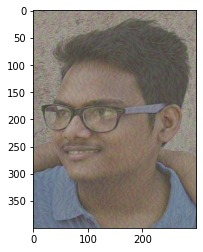

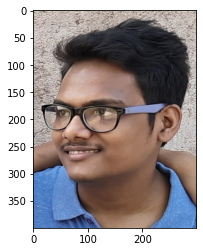

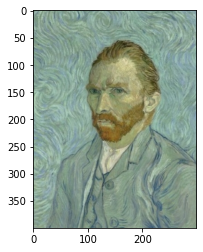

In [78]:
imshow(plt.imread('output/generated_image.jpg'))
plt.show()
imshow(plt.imread('images/c_i.jpeg'))
plt.show()
imshow(plt.imread('images/style.jpeg'))